# Projet Uber Pickups
# Modules d'exploration des données et de "Clustering" K-means et DBSCAN


## Import des modules

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import datetime as dt 

from sklearn.cluster            import KMeans, DBSCAN
from sklearn.metrics            import silhouette_score

## Chargement des données 

In [8]:
liste_mois = ["apr14", "may14", "jun14", "jul14", "aug14", "sep14"] 
# liste_mois = ["sep14"] 

df = pd.DataFrame()
for mois in liste_mois :
    df_mois = pd.read_csv("uber-trip-data/uber-raw-data-" + mois + ".csv")
    print(mois, df_mois.shape)
    df = pd.concat([df, df_mois])

print()
print(df.shape)
df.describe(include="all")

apr14 (564516, 4)
may14 (652435, 4)
jun14 (663844, 4)
jul14 (796121, 4)
aug14 (829275, 4)
sep14 (1028136, 4)

(4534327, 4)


,Date/Time,Lat,Lon,Base
count,4534327,4.534327e+06,4.534327e+06,4534327
unique,260093,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02617
freq,97,NaN,NaN,1458853
mean,NaN,4.073926e+01,-7.397302e+01,NaN
std,NaN,3.994991e-02,5.726670e-02,NaN
min,NaN,3.965690e+01,-7.492900e+01,NaN
25%,NaN,4.072110e+01,-7.399650e+01,NaN
50%,NaN,4.074220e+01,-7.398340e+01,NaN
75%,NaN,4.076100e+01,-7.396530e+01,NaN


## Exploration des données

In [ ]:
for col in ["Lon", "Lat"] :
    fig = px.box(df, x="Lat")
    fig.show()

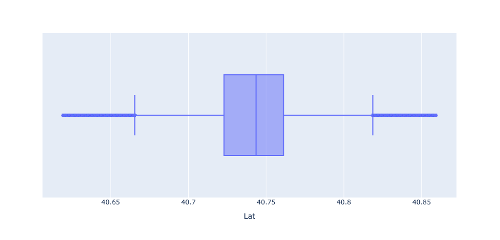
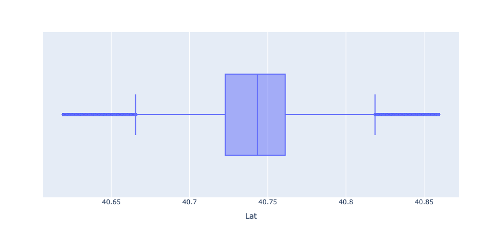

In [9]:
# Colonne 'Date' : Conversion string => datetime et créaation des colonnes "Month", "Weekday", "Hour"
df["Date"] = pd.to_datetime(df["Date/Time"])
df.drop(columns="Date/Time", inplace=True)

df["DayDate"] = df["Date"].apply(lambda d : dt.datetime(year=d.year, month=d.month, day=d.day)) # Jour sans minites ni secondes
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayMonth"] = df["Date"].dt.day
df["DayWeek"] = df["Date"].dt.weekday
df["HourDay"] = df["Date"].dt.hour


In [10]:
# Colonnes "Lat" et "Lon" : suppression des outliers en dehors de (la moyenne +/- 3 écarts type) 

print("Shape : avant", df.shape)
for col in ["Lat", "Lon"] :

    mean_col = df[col].mean()
    std_col = df[col].std()
    limite_min = mean_col - 3 * std_col
    limite_max = mean_col + 3 * std_col
  
    df = df[(df[col] >= limite_min) & (df[col] <= limite_max)]
    
print("Shape : après", df.shape)

Shape : avant (4534327, 10)
Shape : après (4301626, 10)


In [11]:
df.describe(include="all")

,Lat,Lon,Base,Date,DayDate,Year,Month,DayMonth,DayWeek,HourDay
count,4.301626e+06,4.301626e+06,4301626,4301626,4301626,4301626.0,4.301626e+06,4.301626e+06,4.301626e+06,4.301626e+06
unique,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,B02617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1384339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.074131e+01,-7.397828e+01,NaN,2014-07-11 13:07:40.717876992,2014-07-10 22:25:37.636605440,2014.0,6.821044e+00,1.593942e+01,2.963519e+00,1.421089e+01
min,4.061950e+01,-7.413680e+01,NaN,2014-04-01 00:00:00,2014-04-01 00:00:00,2014.0,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.072290e+01,-7.399660e+01,NaN,2014-05-28 06:00:00,2014-05-28 00:00:00,2014.0,5.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01
50%,4.074350e+01,-7.398410e+01,NaN,2014-07-17 07:57:00,2014-07-17 00:00:00,2014.0,7.000000e+00,1.600000e+01,3.000000e+00,1.500000e+01
75%,4.076120e+01,-7.396880e+01,NaN,2014-08-27 20:04:00,2014-08-27 00:00:00,2014.0,8.000000e+00,2.300000e+01,4.000000e+00,1.900000e+01
max,4.085910e+01,-7.381050e+01,NaN,2014-09-30 22:59:00,2014-09-30 00:00:00,2014.0,9.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01


In [12]:
fig = px.bar(df["Month"].value_counts(), title="Nombre de courses par mois de 2014")
fig.show()

In [13]:
PickupsDay = df.groupby("DayDate").size().reset_index(name="pickup_counts")

PickupsDay["DayWeek"] = PickupsDay["DayDate"].dt.day_name()
MeanDay = PickupsDay.groupby("DayWeek")["pickup_counts"].mean()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
MeanDay = MeanDay.reindex(days_order, fill_value=0)

fig = px.bar(MeanDay, title="Nombre moyen de courses par jour de la semaine")
fig.show()

In [14]:
PickupsDay = df.groupby(["DayDate", "HourDay"]).size().reset_index(name="pickup_counts")
MeanHour = PickupsDay.groupby("HourDay")["pickup_counts"].mean()

fig = px.bar(MeanHour, title="Nombre moyen de courses par heure de la journée", range_y=[0, 2500])
fig.show()


In [15]:
for weekday in [[0,'Monday'], [1,'Tuesday'], [2, 'Wednesday'], [3, 'Thursday'], [4, 'Friday'], [5, 'Saturday'], [6, 'Sunday']] :
    
    PickupsDay = df[df["DayWeek"] == weekday[0]].groupby(["DayDate", "HourDay"]).size().reset_index(name="pickup_counts")
    MeanHour = PickupsDay.groupby("HourDay")["pickup_counts"].mean()

    fig = px.bar(MeanHour, title=weekday[1] + " : Nombre moyen de courses par heure de la journée", range_y=[0, 2500])
    fig.show()

In [23]:
# Choix d'un mois et d'un jour et visualisation de la densité des courses par heure
mois = 9
jour = 19

df_disp = df[(df["Month"] == mois) & (df["DayMonth"] == jour)]
df_disp = df_disp.sort_values(by= "HourDay", ascending=True)

fig = px.density_mapbox(
    df_disp,
    lat="Lat",
    lon="Lon",
    animation_frame='HourDay', 
    mapbox_style="carto-positron",
    radius = 5,
    zoom = 11.0,
    height = 1024,
    width = 1024,
    title= "Mois : " + str(mois) + ", Jour : " + str(jour) + " => Densité des courses par Heure" 
)
fig.show()

## "Clusturing"

### Identification des "clusters" avec `K-Means`

In [277]:
# Choix d'un jour d'une heure pour une clusturisation des positions des courses
# jour_semaine = 5
heure = 17

mois = 9
jour = 19

# df_kmeans = df[(df["DayWeek"] == jour_semaine) & (df["HourDay"] == heure)][["Lat", "Lon"]]
df_kmeans = df[(df["Month"] == mois) & (df["DayMonth"] == jour) & (df["HourDay"] == heure)][["Lat", "Lon"]]

print(df_kmeans.shape)


fig = px.density_mapbox(
    df_kmeans,
    lat="Lat",
    lon="Lon",
    mapbox_style="carto-positron",
    radius=5,
    zoom = 11.0,
    height = 1024,
    width = 1024,
    title= "Jour : " + str(jour) + "/" + str(mois) + ", Heure : " + str(heure) + "  - (Densité)" 
)
fig.show()


(2784, 2)


In [278]:
wcss = []
Silhouettes = []
nb_clusters = list(range(2, 15))

for n in nb_clusters :
  kmeans = KMeans(n_clusters = n, random_state = 42, n_init = "auto") 
  kmeans.fit(df_kmeans)
  wcss.append(kmeans.inertia_)
  Silhouettes.append(silhouette_score(df_kmeans, kmeans.predict(df_kmeans)))

df_clusters = pd.DataFrame({'nb_clusters' : nb_clusters , 'wcss' : wcss, 'silhouette' : Silhouettes}).set_index('nb_clusters')


fig = px.line(df_clusters, y="wcss", title="wcss")
fig.show()
fig = px.bar(df_clusters, y="silhouette", title="Silouhette")
fig.show()

In [279]:
df_kmeans_clusters = df_kmeans.copy()

k_optimal = 5 # nombre de clusters retenu
kmeans = KMeans(n_clusters=k_optimal, random_state = 42, n_init='auto') 
df_kmeans_clusters['cluster'] = kmeans.fit_predict(df_kmeans)

In [280]:
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Lat', 'Lon'])

df_kmeans_clusters['cluster'] = df_kmeans_clusters['cluster'].astype(str)

fig = px.scatter_mapbox(
  df_kmeans_clusters, 
  lat="Lat", 
  lon="Lon", 
  opacity = 0.5,
  mapbox_style = "carto-positron",  
  color='cluster',
  zoom = 11.0,
  height = 1024,
  width = 1024,
  title= "Jour : " + str(jour) + "/" + str(mois) + ", Heure : " + str(heure) + "  - (Clusters)"  
)

fig.add_trace(go.Scattermapbox(
    lat=kmeans_centroids['Lat'],
    lon=kmeans_centroids['Lon'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=12,           
        color='black',          
    ),
    name='Centroids'       
))

fig.show()

### Identification des "clusters" avec `DBSCAN`

In [284]:
# Choix d'un jour d'une heure pour une clusturisation des positions des courses
# jour_semaine = 5
heure = 17

mois = 9
jour = 19

# df_kmeans = df[(df["DayWeek"] == jour_semaine) & (df["HourDay"] == heure)][["Lat", "Lon"]]
df_dbscan = df[(df["Month"] == mois) & (df["DayMonth"] == jour) & (df["HourDay"] == heure)][["Lat", "Lon"]]

print(df_dbscan.shape)


fig = px.density_mapbox(
    df_dbscan,
    lat="Lat",
    lon="Lon",
    mapbox_style="carto-positron",
    radius=3,
    zoom = 11.0,
    height = 1024,
    width = 1024,
    title= "Jour : " + str(jour) + "/" + str(mois) + ", Heure : " + str(heure) + "  - (Densité)"
) 

fig.show()

(2784, 2)


In [285]:
# Après plusieurs itérations sur (epsilon et min_samples)
epsilon = 0.005
min_samples = 6


dbscan = DBSCAN(eps = epsilon, min_samples = min_samples, metric = "euclidean", algorithm = "auto")

dbscan.fit(df_dbscan)                                                                   

df_dbscan_cluster = df_dbscan.copy()
df_dbscan_cluster['cluster'] = dbscan.labels_

print("Clusters : ",set(dbscan.labels_))
print("Taux d'observations clustérisées : ", (df_dbscan_cluster['cluster'] != -1).sum()/len(df_dbscan))

Clusters :  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
Taux d'observations clustérisées :  0.9242097701149425


In [286]:


df_dbscan_cluster['cluster'] = df_dbscan_cluster['cluster'].astype(str)

db_dbscan_disp = df_dbscan_cluster[df_dbscan_cluster['cluster'] != "-1"] # sans le cluster "autres"

fig = px.scatter_mapbox(
  db_dbscan_disp,
  lat="Lat", 
  lon="Lon", 
  opacity = 1,
  mapbox_style = "carto-positron",  
  color='cluster',
  zoom = 11.0,
  height = 1024,
  width = 1024,
  title= "Jour : " + str(jour) + "/" + str(mois) + ", Heure : " + str(heure) + "  - (Clusters)"
)
fig.show()